In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
# Load  Train dataset
data = pd.read_excel("../Dataset/TrainDataset2024.xls")


In [ ]:
data.info()


In [ ]:
data.describe()


In [ ]:
# replace 999 -> NaN
data.replace(999, np.nan, inplace=True)
data.isnull().sum()


In [ ]:
# 对于分类变量，用众数填充
categorical_features = ['ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType',
                        'LNStatus', 'TumourStage', 'Gene']
for col in categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    data[col] = imputer_cat.fit_transform(data[[col]])


In [ ]:
# Check imbalance 
print(f"Ratio of '1' in pCR is {(data['pCR (outcome)'] == 1).sum() / data['pCR (outcome)'].count()}")
# This Indicates imbalance exsists, potential optimize point

In [ ]:
# 对于数值变量，用中位数填充
# numerical_features = [col for col in data.columns if
#                       col not in categorical_features + ['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']]
numerical_features = [
    col for col in data.columns
    if data[col].dtype in ['float64', 'int64'] and col not in categorical_features + ['ID', 'pCR (outcome)',
                                                                                      'RelapseFreeSurvival (outcome)']
]

imputer_num = SimpleImputer(strategy='median')
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])


In [ ]:
missing_ratio = data[numerical_features].isnull().mean()
print(missing_ratio[missing_ratio > 0])


In [ ]:
missing_ratio_categorical = data[categorical_features].isnull().mean()
print(missing_ratio_categorical[missing_ratio_categorical > 0])


In [ ]:
print(data.isnull().sum().sum())  # 输出所有缺失值总数


In [ ]:
print(data[numerical_features].describe())


In [ ]:
missing_columns = data.isnull().sum()[data.isnull().sum() > 0]
print(missing_columns)


In [ ]:
data = data.dropna(subset=['pCR (outcome)'])  # 删除含缺失值的行

missing_columns = data.isnull().sum()[data.isnull().sum() > 0]
print(missing_columns)


In [ ]:
# Step 2: 异常值检测和处理
# 使用箱线图法检测异常值（示例以 Tumour Proliferation 为例）
for col in numerical_features:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # 替换异常值为边界值
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])


In [ ]:
# Step 3: 数据归一化
# 选择需要归一化的列（通常是数值型特征）
scaler = StandardScaler()  # 或者使用 StandardScaler
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [ ]:
plt.figure(figsize=(8, 4))
plt.boxplot(data['Proliferation'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Tumour Proliferation')
plt.xlabel('Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# # 设置子图网格的行和列数
# n_cols = 3  # 每行显示的箱线图数量
# n_rows = (len(numerical_features) + n_cols - 1) // n_cols  # 计算行数
#
# # 创建一个包含所有箱线图的图形
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
# axes = axes.flatten()  # 将轴展平为一维数组，方便迭代
#
# # 绘制每个特征的箱线图
# for i, col in enumerate(numerical_features):
#     axes[i].boxplot(data[col], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
#     axes[i].set_title(f'Boxplot of {col}')
#     axes[i].set_xlabel('Value')
#     axes[i].grid(axis='x', linestyle='--', alpha=0.7)
#
# # 移除多余的子图框架
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])
#
# # 调整布局以避免重叠
# plt.tight_layout()
# plt.show()


In [ ]:
# 选择 AGE 到 GENE 的列
selected_columns = data.loc[:, 'Age':'Gene']

# Step 1: 绘制箱线图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: 绘制相关性热图
# 计算相关性矩阵
corr_matrix = selected_columns.corr()

# 使用 Seaborn 绘制热成像分布图

plt.figure(figsize=(10, 8))

# 创建掩码
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 使用 Seaborn 绘制热成像分布图（仅上三角）
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")

plt.show()

# Step 3: 绘制直方图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Step 4: 数据划分
# 提取特征和目标变量
X = data.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'])  # 去除 ID 和目标列
X_pCr = data[data['pCR (outcome)'].isin([0, 1])]
X_pCr = X_pCr.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'])


In [ ]:
# 分类任务目标
# remove when pCR is absent and pCR is the target
y_pcr = data[data['pCR (outcome)'].isin([0, 1])]
y_pcr = y_pcr['pCR (outcome)']
y_rfs = data['RelapseFreeSurvival (outcome)']  # 回归任务目标


In [ ]:
print(data['pCR (outcome)'].isnull().sum())  # 检查分类任务目标变量的缺失值
print(data['RelapseFreeSurvival (outcome)'].isnull().sum())  # 检查回归任务目标变量的缺失值


In [ ]:
print(y_pcr.value_counts())  # 分类任务的类别分布
print(y_rfs.describe())  # 回归任务的目标变量分布统计


In [ ]:
# 检查分类目标变量的完整性
y_pcr = data[data['pCR (outcome)'].notnull() & data['pCR (outcome)'].isin([0, 1])]['pCR (outcome)']

# 检查回归目标变量的完整性
y_rfs = data[data['RelapseFreeSurvival (outcome)'].notnull()]['RelapseFreeSurvival (outcome)']

# 检查目标变量的分布
print("pCR (outcome) distribution:")
print(y_pcr.value_counts())
print("\nRelapseFreeSurvival (outcome) statistics:")
print(y_rfs.describe())


In [ ]:
# 只选择数值列
numeric_data = data.select_dtypes(include=['number'])
corr_matrix = numeric_data.corr()

# 打印与 pCR (outcome) 的相关性排序
print("Correlation with pCR (outcome):")
print(corr_matrix['pCR (outcome)'].sort_values(ascending=False))

# 打印与 RelapseFreeSurvival (outcome) 的相关性排序
print("\nCorrelation with RelapseFreeSurvival (outcome):")
print(corr_matrix['RelapseFreeSurvival (outcome)'].sort_values(ascending=False))


In [ ]:
# 查看非数值列
non_numeric_columns = data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)


In [ ]:
# 筛选与 pCR 和 RelapseFreeSurvival 最相关的特征
top_features_pcr = corr_matrix['pCR (outcome)'].abs().sort_values(ascending=False).head(10).index
top_features_rfs = corr_matrix['RelapseFreeSurvival (outcome)'].abs().sort_values(ascending=False).head(10).index

# 打印最相关的特征
print("Top features for pCR (outcome):", top_features_pcr)
print("Top features for RelapseFreeSurvival (outcome):", top_features_rfs)

# 提取相关性高的特征子集
X_pcr_top = data[top_features_pcr]
X_rfs_top = data[top_features_rfs]


In [ ]:
# 按 8:2 分层划分训练集和验证集
X_train_pcr, X_val_pcr, y_train_pcr, y_val_pcr = train_test_split(
    X_pCr, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)
X_train_rfs, X_val_rfs, y_train_rfs, y_val_rfs = train_test_split(
    X, y_rfs, test_size=0.2, random_state=42
)


In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(categorical_features=categorical_features, random_state=42)
#smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pcr, y_train_pcr)
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


In [ ]:
# 检查 y_train_resampled 数据类型
print("Before conversion, dtype of y_train_resampled:", y_train_resampled.dtype)

# 转换为整型
y_train_resampled = y_train_resampled.astype(int)

# 确认转换结果
print("After conversion, dtype of y_train_resampled:", y_train_resampled.dtype)

# 使用 np.bincount 检查类别分布
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


In [ ]:
# Step 5: 检查处理结果
print("训练集和验证集的大小：")
print("PCR 训练集:", X_train_resampled.shape, "验证集:", X_val_pcr.shape)
print("RFS 训练集:", X_train_rfs.shape, "验证集:", X_val_rfs.shape)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 比较第一个特征的分布
sns.kdeplot(X_train_resampled.iloc[:, 0], label="Train", shade=True)
sns.kdeplot(X_val_pcr.iloc[:, 0], label="Validation", shade=True)
plt.title("Feature Distribution Comparison")
plt.legend()
plt.show()


In [ ]:
for feature in ['Gene', 'HER2', 'PgR', 'ER']:
    sns.kdeplot(X_train_resampled[feature], label="Train", shade=True)
    sns.kdeplot(X_val_pcr[feature], label="Validation", shade=True)
    plt.title(f"Feature Distribution Comparison - {feature}")
    plt.legend()
    plt.show()


In [ ]:
from scipy.stats import ks_2samp

features_to_check = ['Gene', 'HER2', 'PgR', 'ER']
for feature in features_to_check:
    ks_stat, p_value = ks_2samp(X_train_resampled[feature], X_val_pcr[feature])
    print(f"{feature}: KS Statistic={ks_stat}, p-value={p_value}")


PCA Components (contribution to original features):
           Age        ER       PgR      HER2  TrippleNegative  ChemoGrade  \
PC1   0.004922 -0.013757 -0.007597  0.001606         0.012527    0.005315   
PC2   0.001095 -0.004643 -0.006395 -0.016303         0.009586    0.009758   
PC3   0.025891  0.011873  0.012158  0.000459        -0.013508   -0.024330   
PC4  -0.032459 -0.003062 -0.001082  0.005832        -0.001373    0.014609   
PC5   0.036558  0.026858  0.020862  0.006323        -0.030098   -0.018294   
PC6  -0.086339 -0.023673 -0.049085 -0.015274         0.027603    0.004044   
PC7   0.266234  0.015328 -0.014978 -0.002736         0.008124    0.003903   
PC8   0.077297 -0.026868 -0.025744 -0.028261         0.016053    0.000087   
PC9  -0.067196 -0.009594  0.032589 -0.014354         0.008785   -0.052662   
PC10  0.121260 -0.148450 -0.138342 -0.031371         0.135806    0.097204   
PC11  0.497407  0.154680  0.111192  0.044571        -0.179183   -0.198958   
PC12  0.132581 -0.019372

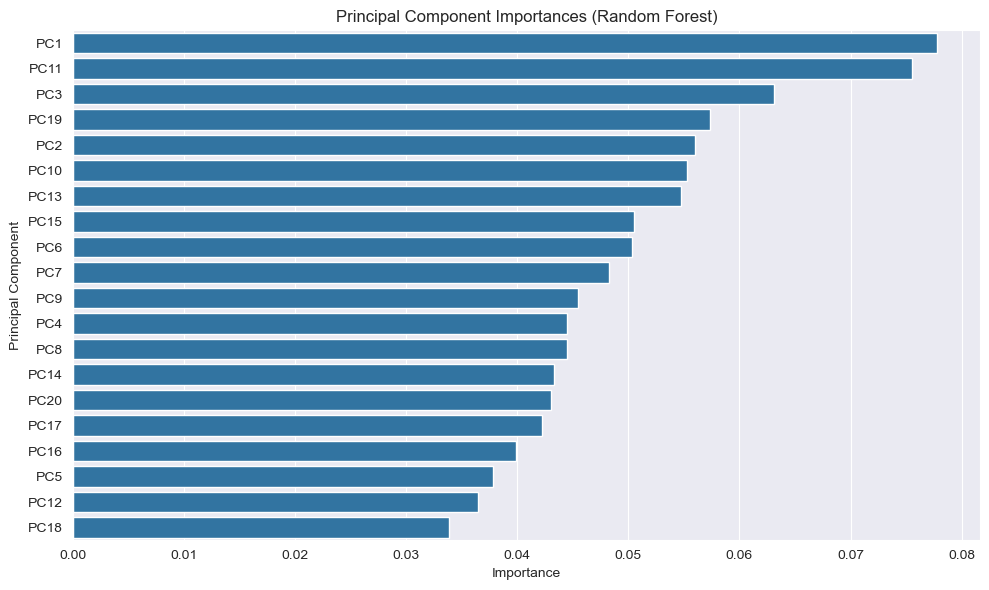

Original Feature Importances (from PCA + Random Forest):
                                      Feature  Importance
0                                         Age    0.083079
9                                 TumourStage    0.073162
6                               Proliferation    0.055147
11                  original_shape_Elongation    0.045076
12                    original_shape_Flatness    0.043802
..                                        ...         ...
25           original_firstorder_10Percentile   -0.018282
4                             TrippleNegative   -0.019450
100  original_glszm_HighGrayLevelZoneEmphasis   -0.030350
99           original_glszm_GrayLevelVariance   -0.031167
30               original_firstorder_Kurtosis   -0.047698

[118 rows x 2 columns]


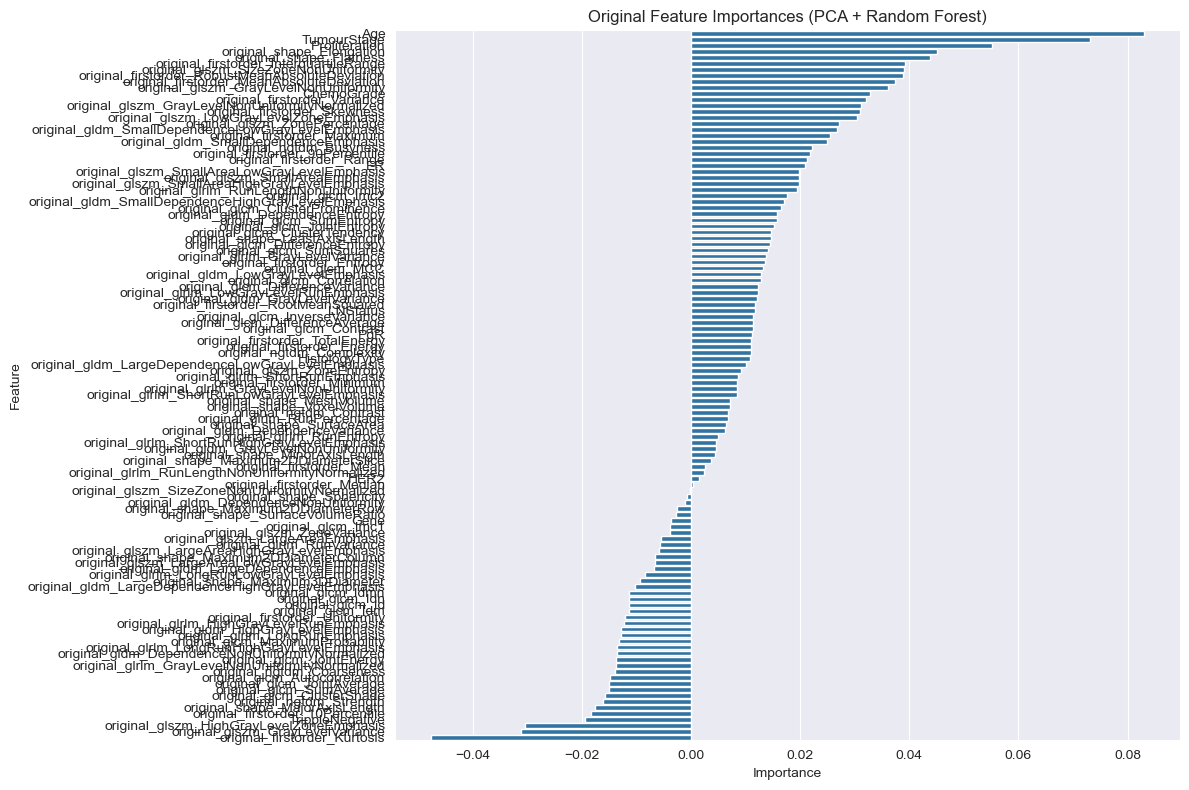

In [44]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# PCA降维
n_components = 20  # 保留20个主成分
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_pcr)
X_val_reduced = pca.transform(X_val_pcr)

# 计算每个主成分对原始特征的贡献
pca_components = pd.DataFrame(pca.components_, columns=X_train_pcr.columns,
                              index=[f"PC{i + 1}" for i in range(n_components)])

# 打印主成分贡献表
print("PCA Components (contribution to original features):")
print(pca_components)

# 使用PCA降维后的特征训练随机森林模型
model = RandomForestClassifier(random_state=42)
model.fit(X_train_reduced, y_train_pcr)

# 提取PCA主成分的重要性
pca_importances = pd.DataFrame({
    'Principal Component': [f"PC{i + 1}" for i in range(n_components)],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 打印PCA主成分的重要性
print("Principal Component Importances:")
print(pca_importances)

# 绘制PCA主成分的重要性
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Principal Component', data=pca_importances)
plt.title("Principal Component Importances (Random Forest)")
plt.tight_layout()
plt.show()

# 根据主成分的重要性反推原始特征的重要性
original_feature_importances = np.dot(pca_importances['Importance'], pca_components.values)

# 创建原始特征的重要性表
original_feature_importances_df = pd.DataFrame({
    'Feature': X_train_pcr.columns,
    'Importance': original_feature_importances
}).sort_values(by='Importance', ascending=False)

# 打印原始特征的重要性
print("Original Feature Importances (from PCA + Random Forest):")
print(original_feature_importances_df)

# 绘制原始特征的重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=original_feature_importances_df)
plt.title("Original Feature Importances (PCA + Random Forest)")
plt.tight_layout()
plt.show()


[0.37478676 0.55135531 0.66723516 0.75623631 0.80732661 0.83568094
 0.8600358  0.8835733  0.89587094 0.90641839 0.91595099 0.92427626
 0.93167946 0.93857765 0.94424028 0.94979484 0.95421897 0.95798127
 0.96169355 0.96522321]


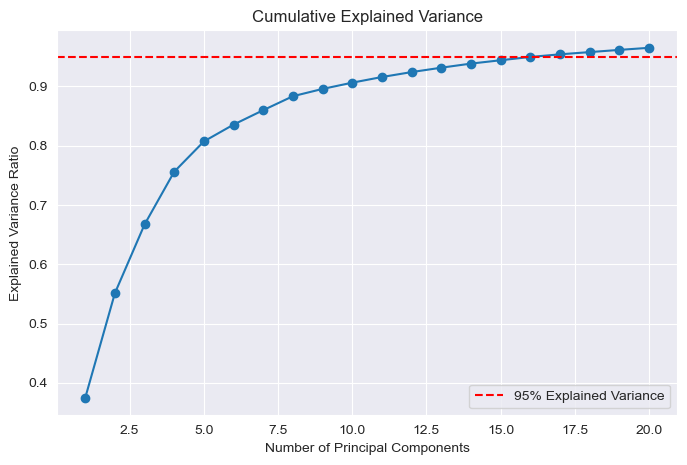

In [45]:
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(explained_variance_ratio)  # 打印累计解释方差比例

# 绘制解释方差图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.show()


In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# 设定阈值
threshold = 0.01

# 训练随机森林模型获取特征重要性
model = RandomForestClassifier(random_state=42)
model.fit(X_train_pcr, y_train_pcr)

# 提取特征重要性
feature_importances = pd.DataFrame({
    'Feature': X_train_pcr.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 打印所有特征的重要性
print("Feature Importances:")
print(feature_importances)

# 筛选重要性大于等于阈值的特征
selected_features = feature_importances[feature_importances['Importance'].abs() >= threshold]['Feature']
print(f"\nSelected features (Importance >= {threshold}):")
print(selected_features)

# 构建新的训练和验证数据集
X_train_filtered = X_train_pcr[selected_features]
X_val_filtered = X_val_pcr[selected_features]

print("\nShape of filtered training set:", X_train_filtered.shape)
print("Shape of filtered validation set:", X_val_filtered.shape)


Feature Importances:
                                          Feature  Importance
29         original_firstorder_InterquartileRange    0.021089
12                        original_shape_Flatness    0.018033
16            original_shape_Maximum2DDiameterRow    0.017958
109  original_glszm_SmallAreaLowGrayLevelEmphasis    0.016858
3                                            HER2    0.016793
..                                            ...         ...
49                original_glcm_DifferenceAverage    0.002524
5                                      ChemoGrade    0.001911
4                                 TrippleNegative    0.001749
8                                        LNStatus    0.001145
7                                   HistologyType    0.001137

[118 rows x 2 columns]

Selected features (Importance >= 0.01):
29                original_firstorder_InterquartileRange
12                               original_shape_Flatness
16                   original_shape_Maximum2DDiameterRow